In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
result = engine.execute("SELECT * FROM station").fetchall()
print(result[:5])

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]


In [12]:
result = engine.execute("SELECT * FROM measurement").fetchall()
print(result[:5])

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0), (2, 'USC00519397', '2010-01-02', 0.0, 63.0), (3, 'USC00519397', '2010-01-03', 0.0, 74.0), (4, 'USC00519397', '2010-01-04', 0.0, 76.0), (5, 'USC00519397', '2010-01-06', None, 73.0)]


In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [14]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x171f9c0f3d0>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0}

# Exploratory Climate Analysis

In [15]:
session.query(Measurement.date).order_by(Measurement.date).first().date

'2010-01-01'

In [16]:
latest_date = session.query(func.max(Measurement.date)).all()
latest_date = list(np.ravel(latest_date))[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date

datetime.datetime(2017, 8, 23, 0, 0)

[Text(0, 0, '2016-08-23'),
 Text(200, 0, '2016-09-23'),
 Text(400, 0, '2016-10-24'),
 Text(600, 0, '2016-11-26'),
 Text(800, 0, '2016-12-26'),
 Text(1000, 0, '2017-01-28'),
 Text(1200, 0, '2017-02-28'),
 Text(1400, 0, '2017-04-02'),
 Text(1600, 0, '2017-05-04'),
 Text(1800, 0, '2017-06-08'),
 Text(2000, 0, '2017-07-10'),
 Text(2200, 0, '2017-08-16')]

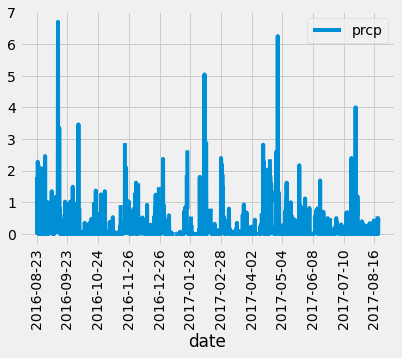

In [66]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# quey date to find the latest dates
latest_date = session.query(func.max(Measurement.date)).all()
# extract the string from the query
latest_date = list(np.ravel(latest_date))[0]
# convert the date string into datetime
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

# extraxct year, month, day independently 
latest_year = int(dt.datetime.strftime(latest_date, '%Y'))
latest_month = int(dt.datetime.strftime(latest_date, '%m'))
latest_day = int(dt.datetime.strftime(latest_date, '%d'))


today = dt.date(latest_year, latest_month, latest_day)
# # Calculate the date 1 year ago from the last data point in the database
date_year_before = today - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_ago_data = session.query(Measurement.prcp, Measurement.date)\
                            .filter(Measurement.date >= date_year_before)\
                            .filter(Measurement.date < today).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
year_ago_df = pd.DataFrame(year_ago_data , columns=['prcp', 'date'])
year_ago_df.set_index("date", inplace=True)

# Sort the dataframe by date
year_ago_df = year_ago_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
ax = year_ago_df.plot(use_index=True, y='prcp')
x_ticks = np.arange(0, year_ago_df.shape[0], 200)
ax.set_xticks(x_ticks)
ax.set_xticklabels([year_ago_df.index[i] for i in x_ticks], rotation=90)


In [67]:
today

datetime.date(2017, 8, 23)

In [9]:
latest_date

In [70]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_ago_df.describe()

,prcp
count,2017.000000
mean,0.177367
std,0.461568
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
session.query(Measurement.station).distinct().count()

9

In [19]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(func.distinct(Measurement.station)).count()
stations_count

9

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                            .group_by(Measurement.station)\
                            .order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station_id = most_active_stations[0].station
# query for the most active station name
active_station_name = session.query(Station.name).filter_by(station = active_station_id)
active_station_name = active_station_name[0].name
print(f'{active_station_name}, ID: {active_station_id} is the most active station')

# query for the temperatures
highest_temp = (session.query(Measurement.tobs).filter(Measurement.station == active_station_id)\
                      .order_by(Measurement.tobs.desc()).first())
print(f'The highest temperature of {active_station_name} is {highest_temp[0]} degree')

# lowest temp
lowest_temp = session.query(Measurement.tobs).filter(Measurement.station == active_station_id)\
                    .order_by(Measurement.tobs.asc()).first()
print(f'The lowest temperature of {active_station_name} is {lowest_temp[0]} degree')

# average temp 
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == active_station_id)
print(f"The average temperature of the most active station is {'{0:.3}'.format(avg_temp[0][0])} degree")

WAIHEE 837.5, HI US, ID: USC00519281 is the most active station
The highest temperature of WAIHEE 837.5, HI US is 85.0 degree
The lowest temperature of WAIHEE 837.5, HI US is 54.0 degree
The average temperature of the most active station is 71.7 degree


In [53]:
#alternative to find the temperatures of the most active station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
       .filter(Measurement.station == active_station_id).all()

[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

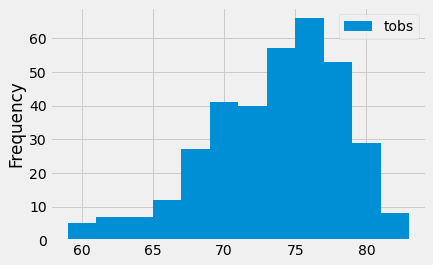

In [59]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempData = session.query(Measurement.tobs).filter(Measurement.station == active_station_id)\
                                          .filter(Measurement.date >= date_year_before)\
                                          .filter(Measurement.date < today).all()

# convert data to dataframe
tempData_df = pd.DataFrame(tempData, columns=['tobs'])

tempData_df.plot.hist(bins=12)

## Bonus Challenge Assignment

In [60]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [81]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
today1 = dt.datetime.today().strftime('%Y-%m-%d')
today = dt.datetime.strptime(today1, '%Y-%m-%d')
start_date = today - dt.timedelta(days=1825)
end_date = start_date + dt.timedelta(days=10)
tmin, tavg, tmax = calc_temps(start_date, end_date)[0]



([], [])

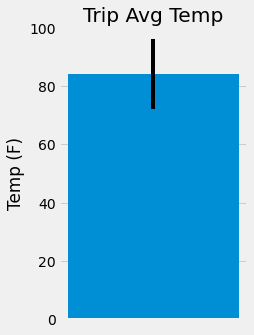

In [83]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig = plt.figure(figsize=(3,5))
plt.subplot()
plt.bar(x=0, height=tmax, yerr=(tmax-tmin))
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.xticks([])

In [87]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station, Station.name, Station.latitude, Station.longitude, 
      Station.elevation, func.sum(Measurement.prcp)]
raindall_data = session.query(*sel).filter(Measurement.station == Measurement.station)\
                                   .filter(Measurement.date >= start_date)\
                                   .filter(Measurement.date <= end_date)\
                                   .group_by(Station.station)\
                                   .order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_df = pd.DataFrame(np.array(raindall_data))
rainfall_df = rainfall_df.rename(columns={0: "Station", 1: "Location", 
                                          2: "Total Precipitation", 3: "Latitude", 
                                          4: "Longitude", 5: "Elevation"})
rainfall_df

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,14.250000000000002
1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,14.250000000000002
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,14.250000000000002
3,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6,14.250000000000002
4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9,14.250000000000002
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,14.250000000000002
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,14.250000000000002
7,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,14.250000000000002
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.3152,-157.9992,0.9,14.250000000000002


In [88]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [92]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
trip_days = 10
trip_date_list = [(start_date + dt.timedelta(days=i)).strftime('%m-%d') for i in range(trip_days)]
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_normal = [daily_normals(date)[0] for date in trip_date_list]
trip_normal

[(70.0, 76.30188679245283, 83.0),
 (72.0, 76.63793103448276, 83.0),
 (68.0, 75.89090909090909, 83.0),
 (69.0, 75.46296296296296, 82.0),
 (69.0, 76.9245283018868, 83.0),
 (69.0, 75.78846153846153, 81.0),
 (70.0, 76.20370370370371, 84.0),
 (69.0, 76.55555555555556, 81.0),
 (67.0, 76.89090909090909, 84.0),
 (71.0, 76.4423076923077, 86.0)]

In [94]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normal_df = pd.DataFrame(trip_normal, columns=['tmin', 'tavg', 'tmax'])
trip_normal_df

,tmin,tavg,tmax
0,70.0,76.301887,83.0
1,72.0,76.637931,83.0
2,68.0,75.890909,83.0
3,69.0,75.462963,82.0
4,69.0,76.924528,83.0
5,69.0,75.788462,81.0
6,70.0,76.203704,84.0
7,69.0,76.555556,81.0
8,67.0,76.890909,84.0
9,71.0,76.442308,86.0


C:\Users\Huy Dinh\AppData\Local\Temp\ipykernel_8120\1858348699.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(trip_date_list, rotation=45)


[Text(-2.0, 0, '07-17'),
 Text(0.0, 0, '07-18'),
 Text(2.0, 0, '07-19'),
 Text(4.0, 0, '07-20'),
 Text(6.0, 0, '07-21'),
 Text(8.0, 0, '07-22'),
 Text(10.0, 0, '07-23')]

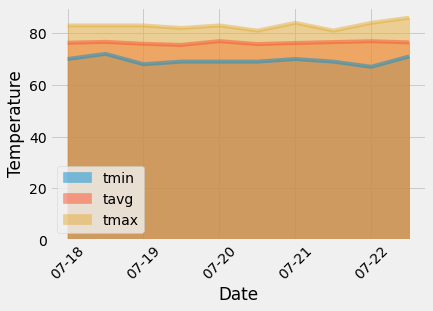

In [96]:
# Plot the daily normals as an area plot with `stacked=False`
plot = trip_normal_df.plot.area(stacked=False)
plot.set_ylabel('Temperature')
plot.set_xlabel('Date')
plot.set_xticklabels(trip_date_list, rotation=45)